In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Install IPD package
### Option 1 (from source):
1. Clone this github repo
2. Run `pip install -e .[render]` 
    1. Make sure you are using a compatible python version (tested with 3.10.14)
    2. Recommend using a venv

### Option 2 (not available yet):
1. `pip install intrinsic-ipd[render]`

In [2]:
import intrinsic_ipd as ipd
from intrinsic_ipd import IPDataset, IPDCamera, IPDImage
from intrinsic_ipd.constants import CameraFramework
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

## 2. Download (if not exists) and load dataset

In [4]:
ipd_reader = IPDataset("./datasets", "dataset_darkbg_0", IPDCamera.PHOTONEO, download=True, resize=.3) 
ipd_reader.objects

INFO:intrinsic_ipd.ipd:
	Dataset Path:	./datasets/dataset_darkbg_0/test
	Camera Type:	Photoneo (ID: 000)
	Lighting:	ALL
	Resize:		0.3
	Num Scenes:	90


[('gear2', 0),
 ('gear2', 1),
 ('gear2', 2),
 ('gear2', 3),
 ('gear2', 4),
 ('hex_manifold', 0),
 ('hex_manifold', 1)]

## 3. Render

Note that the rendering code uses `pyrender` for offscreen rendering. Please specify a compatible backend. See pyrender's official documentation [here](https://pyrender.readthedocs.io/en/latest/examples/offscreen.html).

INFO:intrinsic_ipd.ipd:Opening image from ./datasets/dataset_darkbg_0/test/000030/000/rgb/000000.png


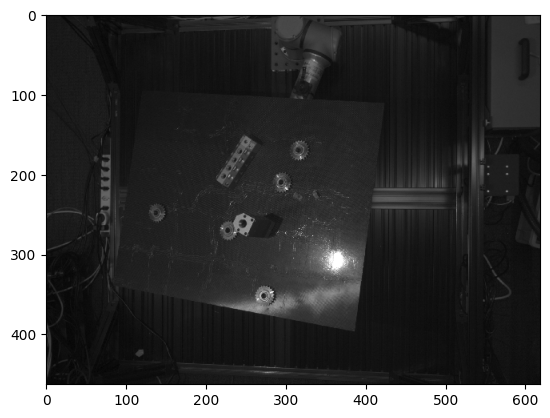

In [5]:
scene = 30
im = ipd_reader.get_img(scene_id=scene, image_type=IPDImage.PHOTONEO_HDR)
plt.imshow(im)

In [6]:
os.environ['PYOPENGL_PLATFORM'] = 'egl'
color, depth = ipd_reader.render(scene_id=scene)

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


## 4. Display or Save

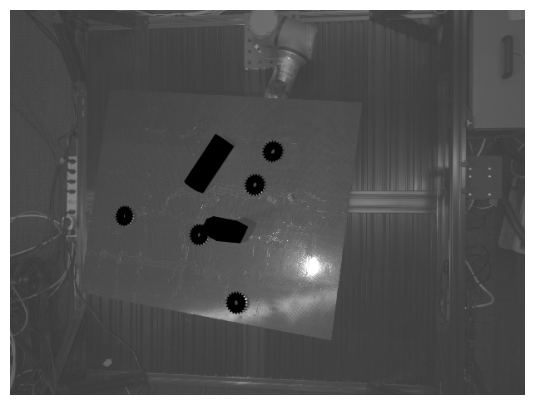

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(im, alpha=.8)
plt.imshow(color, alpha=1)
# plt.show()

In [8]:
# %matplotlib agg

# fig = plt.figure(figsize=(10, 5))
# plt.axis('off')
# plt.imshow(im, alpha=1)
# plt.imshow(color, alpha=1)
# plt.savefig(f'image_{ipd_reader.dataset_id}_{ipd_reader.camera.type}.png', bbox_inches='tight')
# print(f"Image saved to './image_{ipd_reader.dataset_id}_{ipd_reader.camera.type}.png'")

## 5. Get masks of objects

#### 5.1 Render (but don't save) masks for all objects in a scene

In [9]:
masks = ipd_reader.render_masks(scene_id=scene)
mask = masks[ipd_reader.objects[0]]

#### 5.2 Generate and Save Masks for all objects in all scenes

In [10]:
# mask_paths = ipd_reader.create_masks(overwrite=True)
# mask = ipd_reader.get_mask(scene_id=scene, object_name="hex_manifold", object_id=0, resize=None, detect_bounding_box=False)

#### 5.3 Display Mask

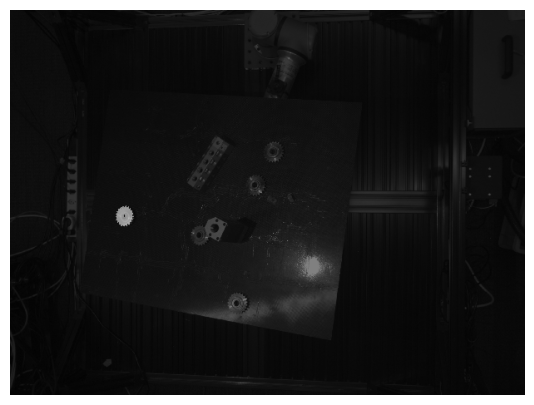

In [11]:
if not mask is None:
    fig = plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(im, alpha=1)
    plt.imshow(mask, alpha=.5)
    plt.show()

# Playground: Inspecting Data

In [21]:
np.set_printoptions(precision=4, suppress=True)

In [22]:
ipd_reader.K

array([[696.078 ,   0.    , 315.939 ],
       [  0.    , 696.045 , 241.5192],
       [  0.    ,   0.    ,   1.    ]])

In [23]:
import trimesh
trimesh.load(ipd_reader.get_mesh_file(ipd_reader.objects[0][0])).vertices

TrackedArray([[-12.9894,  -8.9894,   0.1466],
              [-13.1489,  -8.8893,  -0.8043],
              [-12.9563,  -8.9892,  -1.1091],
              ...,
              [ 18.353 ,   2.6595,  26.0505],
              [ 19.0087,  -2.0967,  28.0564],
              [ 19.3165,  -2.0966,  27.8466]])

In [24]:
_ , o2c_by_object = ipd_reader.get_scene_labels(0)
o2c_by_object[ipd_reader.objects[0]]

array([[   0.8496,    0.3303,    0.4111, -488.3728],
       [   0.4103,    0.0757,   -0.9088,   16.9013],
       [  -0.3313,    0.9408,   -0.0712, 1905.4531],
       [   0.    ,    0.    ,    0.    ,    1.    ]])